### <b><i>Importing libraries

In [1]:
import os
import face_recognition
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import random
import matplotlib.pyplot as plt

#### <b><i>Function for Detecting Face 

In [2]:
def process_and_crop(image_path, target_size=(64, 64)):
    # We will import the image with the help of face_recognition so that don't have to import it manually
    image = face_recognition.load_image_file(image_path)
    
    # This will Detect the face location
    face_locations = face_recognition.face_locations(image)
    
    if len(face_locations) == 0:
        return None  # if no face is detected then we will return none
    
    # Crop the first detected face
    top, right, bottom, left = face_locations[0]
    face_image = image[top:bottom, left:right]
    
    # Here We will resize the image for preparining it to input
    face_image_resized = cv2.resize(face_image, target_size)
    
    return face_image_resized


#### <b><i>Data Loading and Preprocessing

In [3]:
data_directory = r'D:\Face_reco_project (1)\Image_recognition\dataset'

# New directory to store cropped face images
processed_data_directory = r'D:\Face_reco_project (1)\Image_recognition\processed_dataset'

#this all code will run through each folder and every image of it , it will create a new directory with the faces of people only

# os.makedirs(processed_data_directory, exist_ok=True)
# Preprocess and save the cropped face images
# for folder_name in os.listdir(data_directory):
#     folder_path = os.path.join(data_directory, folder_name)
#     save_folder_path = os.path.join(processed_data_directory, folder_name)
    
#     # Create subfolders in the processed data directory
#     os.makedirs(save_folder_path, exist_ok=True)
    
#     if os.path.isdir(folder_path):
#         for img_name in os.listdir(folder_path):
#             img_path = os.path.join(folder_path, img_name)
#             face_image = process_and_crop(img_path)
            
#             if face_image is not None:
#                 # Save the cropped face image
#                 save_path = os.path.join(save_folder_path, img_name)
#                 cv2.imwrite(save_path, face_image[:, :, ::-1])  # Convert RGB to BGR for OpenCV
#             else:
#                 print(f"No face found in {img_name}")

# We Will Use the ImageDataGenerator to load the preprocessed data
datagen = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.3,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train dataset generator
train_generator = datagen.flow_from_directory(
    processed_data_directory,  # Using the processed dataset
    target_size=(64, 64),  
    batch_size=128,  
    class_mode='categorical',  
    subset='training',  
)

# Validation dataset generator
validation_generator = datagen.flow_from_directory(
    processed_data_directory,
    target_size=(64, 64),
    batch_size=128,
    class_mode='categorical',
    subset='validation'
)


Found 10690 images belonging to 30 classes.
Found 4563 images belonging to 30 classes.


#### <b><i>Convolutional Neural Network Model

In [4]:
#This is our CNN Model for Image Training 
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(30, activation='softmax')  #We Have 30 Classes of Celebrities Photos
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

c:\Users\divyansh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 687,070 (2.62 MB)

 Trainable params: 687,070 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

#### <b><i>Accuracy Over 30 Epochs

In [14]:

history1 = model.fit(
    train_generator,
    epochs=30,  
    validation_data=validation_generator
)
model.save("face_recognition_model_30.h5")



Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 386ms/step - accuracy: 0.2583 - loss: 2.5103 - val_accuracy: 0.2790 - val_loss: 2.4490
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 51s 590ms/step - accuracy: 0.3025 - loss: 2.3850 - val_accuracy: 0.3281 - val_loss: 2.3065
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 67s 759ms/step - accuracy: 0.3398 - loss: 2.2354 - val_accuracy: 0.3517 - val_loss: 2.1948
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 66s 745ms/step - accuracy: 0.3701 - loss: 2.1264 - val_accuracy: 0.3837 - val_loss: 2.0668
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 67s 760ms/step - accuracy: 0.4048 - loss: 2.0160 - val_accuracy: 0.3949 - val_loss: 2.0148
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 65s 744ms/step - accuracy: 0.4174 - loss: 1.9961 - val_accuracy: 0.4464 - val_loss: 1.8491
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 67s 757ms/step - accuracy: 0.4576 - loss: 1.8407 - val_accuracy: 0.4543 - val_loss: 1.8126
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 513ms/step - accuracy: 0.4678 - loss: 1.7942 - val_accu

#### <b><i>Accuracy Over 50 Epochs

#### <b><i>To Imporve the model accuracy we had increased the Epoch

In [5]:
history = model.fit(
    train_generator,
    epochs=50,  
    validation_data=validation_generator
)
model.save("face_recognition_model_50.h5")



Epoch 1/50


c:\Users\divyansh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.1318 - loss: 3.2833 - val_accuracy: 0.1481 - val_loss: 3.0690
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 351ms/step - accuracy: 0.1395 - loss: 3.0486 - val_accuracy: 0.1650 - val_loss: 2.9202
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 37s 424ms/step - accuracy: 0.1728 - loss: 2.8841 - val_accuracy: 0.1863 - val_loss: 2.8061
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 84s 957ms/step - accuracy: 0.2029 - loss: 2.7549 - val_accuracy: 0.2389 - val_loss: 2.6213
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 60s 662ms/step - accuracy: 0.2400 - loss: 2.6010 - val_accuracy: 0.2615 - val_loss: 2.5123
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 54s 622ms/step - accuracy: 0.2611 - loss: 2.5035 - val_accuracy: 0.2836 - val_loss: 2.4065
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 523ms/step - accuracy: 0.3007 - loss: 2.3430 - val_accuracy: 0.3344 - val_loss: 2.2417
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - accuracy: 0.3385 - loss: 2.2208 - val_accuracy: 0.3539 

#### <b><i> Visualising the Training Accuracy and Validation Accuracy over Epochs

In [6]:
#Through Plotly we will Visualise the Model Accuracy Over Epochs
import plotly.express as px
import pandas as pd

#Getting accuracy of the model and validation accuracy 
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

#Converting it to DataFrame
data = pd.DataFrame({
    'Epochs': range(len(train_accuracy)),
    'Training Accuracy': train_accuracy,
    'Validation Accuracy': val_accuracy
})
#Visualising the Data
fig = px.line(data, x='Epochs', y=['Training Accuracy', 'Validation Accuracy'],
              labels={'value': 'Accuracy', 'variable': 'Type'},
              title='Model Accuracy Over Epochs',color_discrete_sequence = ['blue','orange'])

fig.show()


#### <b><i>Validation Accuracy Percentage

In [7]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {val_accuracy*100:.2f}%")


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.7164 - loss: 1.0167
Validation accuracy: 71.23%


#### <b><i>Training Accuracy Percentage

In [8]:
# Assuming you have a train_generator for the training set
test_loss, test_accuracy = model.evaluate(train_generator)
print(f"Training accuracy: {test_accuracy*100:.2f}%")


84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 0.7223 - loss: 0.9290
Training accuracy: 72.67%


In [9]:
# Function to detect and crop the face using face_recognition
def process_and_crop(image_path, target_size=(64, 64)):
    try:
        # Load the image using face_recognition
        image = face_recognition.load_image_file(image_path)
        
        # Detect face locations in the image
        face_locations = face_recognition.face_locations(image)
        
        if len(face_locations) == 0:
            print("No face detected.")
            return None, image  # If No face detected, return None for face_image and the original image
        
        # Crop the first detected face
        top, right, bottom, left = face_locations[0]
        face_image = image[top:bottom, left:right]
        
        # Resize the face image to match the model input size
        face_image_resized = cv2.resize(face_image, target_size)
        
        return face_image_resized, image
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None  # Return None in case of any error


#### <b><i>Prediction of New Images

In [11]:
# Load the saved model
model = tf.keras.models.load_model('face_recognition_model_50.h5')

def predict_new_image(img_path):
    # This will Detect and crop the image provided by the person 
    face_image, original_image = process_and_crop(img_path)
    
    if face_image is None:
        return "No face found in the image.", original_image
    
    face_image = np.expand_dims(face_image, axis=0) 
    face_image = face_image / 255.0 
    predictions = model.predict(face_image)
    
    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(predictions[0])
    
    # Map the index to the class label (person's name)
    class_labels = list(train_generator.class_indices.keys()) 
    predicted_class = class_labels[predicted_class_index]
    
    return predicted_class, original_image

#### <b><i>Function for getting sample image from the predicted class folder

In [12]:
# Function to get a sample image from the predicted class folder
def get_sample_image_from_class(class_name, data_directory):
    class_folder = os.path.join(data_directory, class_name)
    
    image_files = [f for f in os.listdir(class_folder) if f.endswith(('.png', '.jpg', '.jpeg','.webp'))]
    
    #Picking up the image from the same class
    sample_image_path = os.path.join(class_folder, random.choice(image_files))

    sample_image = face_recognition.load_image_file(sample_image_path)
    sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    
    return sample_image_rgb

### <b><i>Testing with an Example

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


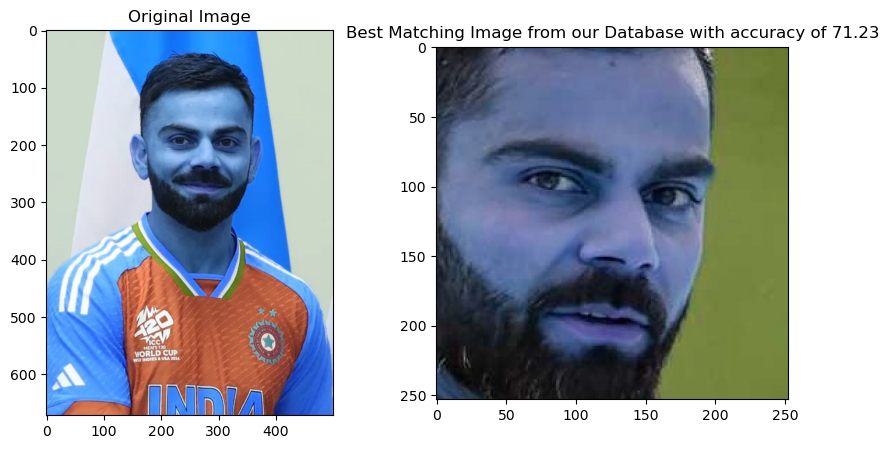

In [30]:
# Example usage:
new_image_path = r"D:\kohli.webp"
#To check other images
#"D:\faciiii\dataset\dhoni\25.jpg"
#"D:\faciiii\dataset\ROHIT_SHARMA\44.jpg"
predicted_class, original_image = predict_new_image(new_image_path)

original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

predicted_class_image = get_sample_image_from_class(predicted_class, data_directory)

plt.figure(figsize=(10, 5))

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title("Original Image")

# Show the predicted class image
plt.subplot(1, 2, 2)
plt.imshow(predicted_class_image)
plt.title(f"Best Matching Image from our Database with accuracy of {val_accuracy*100:.2f}")
plt.show()
